In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2

In [19]:
# Step 1: Load datasets
data_path = '../../data/raw/'
model_save_path = '../../models/naive_bayes/'

# Create model save directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

In [20]:
# Load datasets
print("Loading datasets...")
df_train = pd.read_csv(os.path.join(data_path, 'dataset.csv'))
df_precautions = pd.read_csv(os.path.join(data_path, 'symptom_precaution.csv'))
df_severity = pd.read_csv(os.path.join(data_path, 'Symptom-severity.csv'))
df_description = pd.read_csv(os.path.join(data_path, 'symptom_Description.csv'))
print("Datasets loaded.")

Loading datasets...
Datasets loaded.


In [21]:
# Step 2: Preprocess Training Data
# Identify symptom columns (assuming they are named Symptom_1, Symptom_2, etc.)
symptom_cols = [col for col in df_train.columns if col.startswith('Symptom')]

# Fill NaN values with a placeholder (e.g., 'Unknown') before processing
df_train[symptom_cols] = df_train[symptom_cols].fillna('Unknown')


In [22]:
df_train.head(5)

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
3,Fungal infection,itching,skin_rash,dischromic _patches,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [23]:
# Step 3: Binarize Symptoms
# Combine symptoms for each row into a list, removing placeholders and duplicates
symptoms_per_row = df_train[symptom_cols].apply(lambda row: list(set(str(s).strip() for s in row if s and s != 'Unknown')), axis=1)


In [24]:
symptoms_per_row

0       [itching, nodal_skin_eruptions, skin_rash, dis...
1       [nodal_skin_eruptions, skin_rash, dischromic _...
2       [itching, nodal_skin_eruptions, dischromic _pa...
3               [itching, skin_rash, dischromic _patches]
4              [itching, nodal_skin_eruptions, skin_rash]
                              ...                        
4915    [vomiting, spinning_movements, unsteadiness, h...
4916    [pus_filled_pimples, skin_rash, blackheads, sc...
4917    [continuous_feel_of_urine, bladder_discomfort,...
4918    [small_dents_in_nails, skin_peeling, skin_rash...
4919    [blister, yellow_crust_ooze, red_sore_around_n...
Length: 4920, dtype: object

In [25]:
# Use MultiLabelBinarizer to create binary features for each unique symptom
mlb = MultiLabelBinarizer()
X_binarized = mlb.fit_transform(symptoms_per_row)
unique_symptoms = list(mlb.classes_)  # Get the list of unique symptoms (features)


In [26]:
# Create a new DataFrame with binarized features
X = pd.DataFrame(X_binarized, columns=unique_symptoms)

# Target variable
y = df_train['Disease']
# Encode the target variable 'Disease'
le_disease = LabelEncoder()
y_encoded = le_disease.fit_transform(y)

In [27]:
# Step 4: Feature Selection using SelectKBest
k_best = SelectKBest(chi2, k=20)  # Selecting the top 20 features
X_selected = k_best.fit_transform(X, y_encoded)


In [28]:
# Get the names of the top 20 selected features
selected_features = X.columns[k_best.get_support()]
print("Top 20 Selected Features:", selected_features)


Top 20 Selected Features: Index(['blood_in_sputum', 'brittle_nails', 'coma', 'congestion',
       'enlarged_thyroid', 'increased_appetite', 'loss_of_smell',
       'pain_behind_the_eyes', 'palpitations', 'polyuria',
       'receiving_blood_transfusion', 'receiving_unsterile_injections',
       'redness_of_eyes', 'runny_nose', 'rusty_sputum', 'sinus_pressure',
       'slurred_speech', 'stomach_bleeding', 'swollen_extremeties',
       'throat_irritation'],
      dtype='object')


In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
# Step 2: Apply SMOTE to balance the class distribution by oversampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y_encoded)

In [31]:

# Step 3: Split the resampled data into training and testing sets
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

nb_model = BernoulliNB(alpha=1.0)  # Using Laplace smoothing to handle zero probabilities
nb_model.fit(X_train_resampled, y_train_resampled)

BernoulliNB()

In [32]:
# Predict on the test set
y_pred = nb_model.predict(X_test_resampled)

In [33]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test_resampled, y_pred)
class_report = classification_report(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:", class_report)

Accuracy: 0.2439
Classification Report:               precision    recall  f1-score   support

           0       0.03      1.00      0.06        24
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       0.00      0.00      0.00        24
          14       0.00      0.00      0.00        24
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.

d:\Download\Anaconda\anaconda3\envs\conda_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Download\Anaconda\anaconda3\envs\conda_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Download\Anaconda\anaconda3\envs\conda_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Overall ROC AUC Score: 0.70


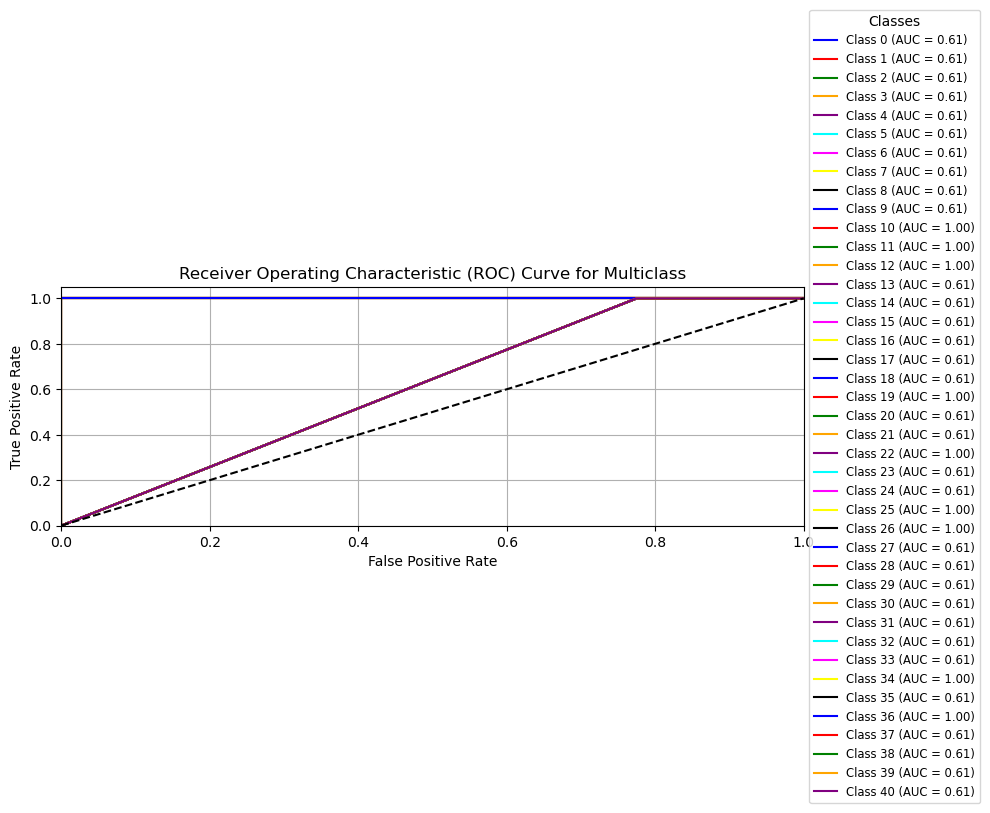

In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the output
y_test_binarized = label_binarize(y_test_resampled, classes=np.unique(y_test_resampled))
n_classes = y_test_binarized.shape[1]

# Step 2: Get prediction probabilities for all classes
y_pred_proba = nb_model.predict_proba(X_test_resampled)

# Step 3: Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Calculate the overall ROC AUC score
overall_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro')  # Use 'macro' for average
print(f'Overall ROC AUC Score: {overall_roc_auc:.2f}')

# Step 5: Plot the ROC curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black']  # Adjust colors as needed

# Create a list of abbreviated class names
abbreviated_class_names = [f'Class {i}' for i in range(n_classes)]

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], label=f'{abbreviated_class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot the overall ROC AUC score
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')

# Adjust legend properties
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title='Classes', title_fontsize='medium')
plt.grid()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:

# Save the model and other artifacts
joblib.dump(nb_model, os.path.join(model_save_path, '../../models/Naive_Bayes/naive_bayes_model.joblib'))
joblib.dump(le_disease, os.path.join(model_save_path, '../../models/Naive_Bayes/disease_label_encoder.joblib'))
joblib.dump(unique_symptoms, os.path.join(model_save_path, '../../models/Naive_Bayes/symptoms_list.joblib'))

# Prepare and save auxiliary data
df_precautions.set_index('Disease', inplace=True)
df_description.set_index('Disease', inplace=True)
df_severity['Symptom'] = df_severity['Symptom'].str.strip()
df_severity.set_index('Symptom', inplace=True)
df_precautions.to_csv(os.path.join(model_save_path, 'precautions_processed.csv'))
df_description.to_csv(os.path.join(model_save_path, 'description_processed.csv'))
df_severity.to_csv(os.path.join(model_save_path, 'severity_processed.csv'))

print("Artifacts saved successfully.")

Artifacts saved successfully.
